# Project 2

## Topic : Stereo reconstruction and Non-linear optimization

#### Instructions
<ul>
    <li> The second project of the course is designed to get you familiar with stereo reconstruction, and non-linear optimization </li>
    <li> Use python for this project. PILLOW and OpenCV are permitted for image I/O. </li>
    <li> Submit this notebook as a zipped file on moodle. The format should be $<$team_id$>$_$<$team_ name$>$.zip. Both members have to submit this zip file. </li>
    <li> A seperate report is not needed if you're coding in the notebook itself. Please provide adequate descriptions of the approaches you've taken. Also mention work distribution for the two members. </li>
    <li> Refer to the late day policy. Start early </li> 
    <li> Download data from here: https://iiitaphyd-my.sharepoint.com/:f:/g/personal/aryan_sakaria_students_iiit_ac_in/Er5C7351IAlFsvwHUesFeSQBQtlSiAS7AORSEJT2qH_8_w?e=ol98k9  </li>
</ul>

----
### PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo camerasprovide  us  with  a  convenient  way  to  generate  dense  point  clouds.Densehere,  in  contrast  tosparse,means all the image points are used for the reconstruction.  In this part of the assignment you will begenerating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds fromeach disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the providedground truth poses. </li>
    <li> Visualize the registered point cloud data, in color.  Use Open3D for this </li>
</ol>
    

In [1]:
#import libraries:
import numpy as np 
# from sklearn.preprocessing import normalize #normalizing gives better results. Experiment with this
import cv2
import open3d as o3d
import matplotlib.pyplot as plt

In [2]:
def read_transformations(filename):
    f = open(filename, 'r')
    data = np.loadtxt(filename)
    transformation_list = data.reshape(len(data),3,4);
    return transformation_list

In [3]:
pcd = o3d.geometry.PointCloud()
pcd_final = o3d.geometry.PointCloud()

calib_mat = np.array([[7.070912e+02, 0.000000e+00, 6.018873e+02],
             [0.000000e+00, 7.070912e+02, 1.831104e+02],
             [0.000000e+00, 0.000000e+00, 1.000000e+00]])

f = calib_mat[0,0]
T = read_transformations('data/poses.txt')
nums = 21
b = 0.53790448812

def convert_img_world(disp_map,Q_mat):
    points = []
    for i in range(len(disp_map)):
        points.append(np.matmul(Q_mat,disp_map[i]))
    return np.array(points)


def get_parallax(disp):
    disp_map = []
    for i in range(disp.shape[0]):
        disp_2 = disp[i]
        for j in range(disp.shape[1]):
            disp_map.append([j,i,disp_2[j],1])
    return np.array(disp_map)


def get_disp(img_l,img_r):
    win_size = 5
    stereo = cv2.StereoSGBM_create(minDisparity = -39,
        numDisparities = 144,
        disp12MaxDiff = 1,
        blockSize=5,
        speckleRange = 32,
        uniquenessRatio = 10,
        speckleWindowSize = 100,
        P1= 8*3* win_size**2,
        P2= 32*3*win_size**2,
        preFilterCap= 63
        )
    num_disp = 144
    min_disp = -39
    
    disp = stereo.compute(img_l, img_r).astype(np.float32)/64.0
    disp = disp-min_disp
    disp = disp/num_disp
    return disp

def getQ_mat(disp,f,w):
    Q_mat = np.array([[ 1,  0,  0, -disp.shape[1]/2],
                  [ 0,  -1,  0, disp.shape[0]/2],
                  [ 0,  0,  0, f],
                  [ 0,  0,  1/b, 0]])
    return Q_mat
    
for i in range(nums):    

    img_l = cv2.imread("data/img2/00000004"+str(60+i)+".png")
    img_r = cv2.imread("data/img3/00000004"+str(60+i)+".png")
    
    disp = get_disp(img_l,img_r)
    
    Q_mat = getQ_mat(disp,f,disp[1])
    disp_map = get_parallax(disp)
    
    points_arr = convert_img_world(disp_map,Q_mat)
    
    colors = cv2.cvtColor(img_l, cv2.COLOR_BGR2RGB)
    colors_ar = np.array(colors[(disp >= disp.min())]/255)
   
    for k in range(4):
        points_arr[:,k] = points_arr[:,k]/points_arr[:,3]

    points_arr = np.matmul(T[i],points_arr.T).T
    thresh = 1500
    mask =((-thresh <= points_arr[:,0]) & (points_arr[:,0] < thresh)&
            (-thresh <= points_arr[:,1]) & (points_arr[:,1] < thresh) &
            (-thresh <= points_arr[:,2]) & (points_arr[:,2] < thresh))
            

    points_arr = points_arr[mask]
    points_arr[:,0] *= -1


    pcd.points = o3d.utility.Vector3dVector(points_arr)
    pcd.colors = o3d.utility.Vector3dVector(colors_ar[mask])
    pcd_final = pcd_final + pcd
    print(60+i)

#Saving the combined pcd 
o3d.io.write_point_cloud("Output.pcd", pcd_final)

output = o3d.io.read_point_cloud("Output.pcd")
o3d.visualization.draw_geometries([output])

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


----
### PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Poses Ground truth 
 [[-8.90929517e+02  5.38387637e+01 -2.56109933e+02 -1.53083396e+05]
 [-3.68165080e+01  7.13415332e+02 -1.52284250e+02  2.00006057e+01]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


Transforms ground truth 
 [[-9.09854768e-01  4.11782636e-02  4.12878417e-01 -1.92843773e+02]
 [ 5.44537786e-02  9.98307203e-01  2.04332712e-02  7.22435448e+00]
 [-4.11338164e-01  4.10740947e-02 -9.10556891e-01 -2.77880277e+01]]


Initialised P from DLP
 [[ 3.20616341e+01 -1.93747852e+00  9.21655800e+00  5.50896991e+03]
 [ 1.32490589e+00 -2.56734829e+01  5.48021064e+00 -7.19790961e-01]
 [ 1.48027138e-02 -1.47812755e-03  3.27679579e-02  1.00000000e+00]]

Initial cost_arr 
 712.6278083526804


Gauss Newton converged at iteration  13
cost  1.187623822830479





P_Optimized 
 [[-8.90928661e+02  5.38386754e+01 -2.56107723e+02 -1.53083119e+05]
 [-3.68143895e+01  7.13415119e+02 -1.52279176e+02  2.04081935e+01]
 [-4.11338163e-01  4.10740946e-02 -9.10556890e-01 -2.77880277e

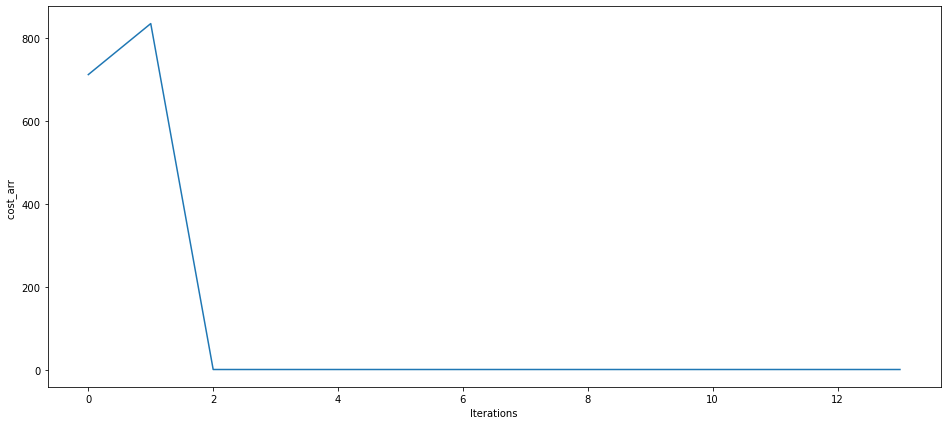

In [4]:
def read_pcd(file_name):
    pcd = o3d.io.read_point_cloud(file_name) 
    pcd_points = np.hstack((np.asarray(pcd.points),np.ones((len(pcd.points),1))))
    return pcd_points


def find_Transfroms_gt(T):
    Transfroms_gt = np.append(T[0],[0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]).reshape(4,4)
    Transfroms_gt = np.linalg.inv(Transfroms_gt)
    return Transfroms_gt


def perform_DLT(x,X):
    a = x[0]
    x = x[:10,:]
    a_X = X[0]
    X = X[:10,:]
    
    for i in range(2):
        x[:,i] = x[:,i]/x[:,2]
  
    a1 = x[:,0]*X[:,2]
    a2 = x[:,0]*X[:,3]
    u = np.vstack((a1,a2))
    v = np.vstack((x[:,0]*X[:,1],u))
    w = np.vstack((x[:,0]*X[:,0],v)).T
   
    a1 = x[:,1]*X[:,2]
    a2 = x[:,1]*X[:,3]
    u_ = np.vstack((a1,a2))
    v_ = np.vstack((x[:,1]*X[:,1],u_))
    w_ = np.vstack((x[:,1]*X[:,0],v_)).T
    
    zeros = np.zeros((len(X),4))
    X = -X
    a = np.hstack((zeros,w))
    a_ = np.hstack((X,w_))
    b = np.hstack((zeros,a_))   
    
    mat = np.vstack((np.hstack((X,a)),b))
    
    U,D,VT = np.linalg.svd(mat)
    
    P = np.array(VT[-1])
    P = P.reshape(3,4)
    
    return P/P[-1,-1]


def get_Jacobian(x,X):
    for i in range(4):
        X[:,i] = X[:,i]/x[:,2]
        
    for i in range(2):
        x[:,i] = x[:,i]/x[:,2]
  
    zeros = np.zeros((len(X),4))
    a1 = x[:,0]*X[:,2]
    a2 = x[:,0]*X[:,3]
    u = np.vstack((a1,a2))
    v = np.vstack((x[:,0]*X[:,1],u))
    w = np.vstack((x[:,0]*X[:,0],v)).T
   
    a1 = x[:,1]*X[:,2]
    a2 = x[:,1]*X[:,3]
    u_ = np.vstack((a1,a2))
    v_ = np.vstack((x[:,1]*X[:,1],u_))
    w_ = np.vstack((x[:,1]*X[:,0],v_)).T

    Jaco = np.vstack((np.hstack((-X,np.hstack((zeros,w)))),np.hstack((zeros,np.hstack((-X,w_))))))
    return Jaco

def get_residual(x,x_ground_truth):
    den = x_ground_truth[:,2]
    res_2= x_ground_truth[:,1]/den
    res_2 -= x[:,1]/x[:,2]
    res_1 = x_ground_truth[:,0]/den
    res_1 -= x[:,0]/x[:,2]
    residual = np.hstack((res_1,res_2))
    residual = residual.reshape(-1,1)
    return residual


def perform_Gauss_newton(P,x_ground_truth,X,nums,tolerance):
    residual = np.zeros(X.shape)
    cost_arr = np.zeros(nums)
    for i in range(nums):
        x = np.matmul(P,X.T).T
        residual = get_residual(x,x_ground_truth) 
        cost_arr[i] = (np.matmul(residual.T,residual)/2/len(X)).item(0)
        J = get_Jacobian(x,X)
        H = np.matmul(J.T,J)
        delta = np.linalg.inv(H)@J.T@residual
        P = (P.reshape(12,1) - delta).reshape(3,4)    
        if(i==0):
            print("\nInitial cost_arr \n",cost_arr[0])
        norm = np.linalg.norm(delta)   
        if(norm<tolerance):
            print("\n")
            print("Gauss Newton converged at iteration ",i)
            print("cost ",cost_arr[i])
            print("\n\n")
            break   
    return P, cost_arr, i
X_ground_truth = read_pcd("Output.pcd")[0::10,:]
Transfroms_gt = find_Transfroms_gt(T)
P_ground_truth = np.matmul(calib_mat,Transfroms_gt[:3,:4])
x_ground_truth = np.matmul(P_ground_truth,X_ground_truth.T).T

P_init = perform_DLT(x_ground_truth,X_ground_truth)
print("Poses Ground truth \n",P_ground_truth)
k_inv = np.linalg.inv(calib_mat)
Transfroms_gt = np.matmul(k_inv,P_ground_truth)
print('\n')
print("Transforms ground truth \n",Transfroms_gt)
print('\n')
print("Initialised P from DLP\n",P_init)


P_optimized, cost_arr, it_conv = perform_Gauss_newton(P_init,x_ground_truth,X_ground_truth,1000,1e-7)
P_optimized = P_ground_truth[-1,-1]*P_optimized/P_optimized[-1,-1] 

print('\n')
print("P_Optimized \n",P_optimized)

k_inv = np.linalg.inv(calib_mat)
T_op = np.matmul(k_inv,P_optimized)
print('\n')
print("T_Output \n",T_op)

def plot(it_conv,cost_arr):
    plt.figure(figsize=(16,7))
    y = cost_arr[0:it_conv+1]
    x = range(it_conv+1)
    plt.plot(x, y)
    plt.xlabel('Iterations')
    plt.ylabel('cost_arr ')


plot(it_conv,cost_arr)